\begin{aligned}
\text{\huge{Correction des données réelles}}
\end{aligned}

## Définition des métriques SSIM et COS_SIM

In [1]:
# Definition de la métrique ssim
import numpy as np
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def ssim(X, Y, K1=1e-4, K2=3e-4):
    """
    Calcule la mesure de similarité structurelle pour les séries temporelles (ssim)
    entre deux séries X et Y.

    Article de référence : Unveiling Structural Similarity in Time Series through Image Similarity Assessment Insights".

    Args:
        X (np.array): La première série temporelle (1D).
        Y (np.array): La deuxième série temporelle (1D).
        K1 (float): Constante de stabilisation pour la tendance.
        K2 (float): Constante de stabilisation pour la variabilité/structure.

    Returns:
        float: La valeur de similarité ssim, comprise entre 0 et 1.
    """
    if X.ndim != 1 or Y.ndim != 1:
        raise ValueError("Les séries temporelles doivent être des tableaux 1D.")
    if len(X) != len(Y):
        raise ValueError("Les séries temporelles doivent avoir la même longueur.")

    m = len(X)
    if m == 0:
        return 1.0 # Deux séries vides sont parfaitement similaires.

    # --- 1. Similarité de Tendance (Trend Similarity) ---
    # Calcul des pentes de régression linéaire
    time_index = np.arange(m)
    mu_X = np.abs(sum((time_index-np.mean(time_index))*(X-np.mean(X))))/sum((time_index-np.mean(time_index))**2)
    # mu_Y = np.polyfit(time_index, Y, 1)[0]
    mu_Y = np.abs(sum((time_index-np.mean(time_index))*(Y-np.mean(Y))))/sum((time_index-np.mean(time_index))**2)

    # --- 2. Mesure de Variabilité (Variability Measurement) ---
    # Calcul des variances
    sigma_X_sq = np.var(X)
    sigma_Y_sq = np.var(Y)

    # --- 3. Analyse de Corrélation Structurelle (Structural Correlation) ---
    # Calcul des fonctions d'autocorrélation (ACF)
    # nlags doit être identique pour les deux séries pour pouvoir les comparer
    nlags = m - 1
    acf_X = acf(X-np.mean(X), nlags=nlags, fft=True)
    acf_Y = acf(Y-np.mean(Y), nlags=nlags, fft=True)
    
    # Calcul de la corrélation cosinus entre les ACFs 
    # Gère le cas où l'un des ACF est nul pour éviter la division par zéro
    norm_acf_X = np.linalg.norm(acf_X)
    norm_acf_Y = np.linalg.norm(acf_Y)
    if norm_acf_X == 0 or norm_acf_Y == 0:
        sigma_XY = 1.0 if norm_acf_X == norm_acf_Y else 0.0
    else:
        sigma_XY = np.dot(acf_X, acf_Y) / (norm_acf_X * norm_acf_Y)

    # --- 4. Combinaison et calcul final ---
    # Calcul des constantes de stabilisation C1 et C2
    # L est la plage dynamique des valeurs des signaux
    L = np.max(np.concatenate([X, Y])) - np.min(np.concatenate([X, Y]))
    C1 = (K1 * L)**2
    C2 = (K2 * L)**2
    
    # 
    numerator = (2 * mu_X * mu_Y + C1) * (2 * sigma_XY + C2)
    denominator = (mu_X**2 + mu_Y**2 + C1) * (sigma_X_sq + sigma_Y_sq + C2)

    if denominator == 0:
      return 1.0 if numerator == 0 else 0.0
    ind = numerator / denominator
    TS3IM = 2*ind*(sigma_X_sq+C2)/(2*sigma_XY+C2)
    return TS3IM 

In [2]:
# Métrique Cos_sim
import numpy as np

def cosine_similarity(A, B):
    # The time-series data sets should be normalized.
    A_norm = (A - np.mean(A)) / np.std(A)
    B_norm = (B - np.mean(B)) / np.std(B)

    # Determining the dot product of the normalized time series data sets.
    dot_product = np.dot(A_norm, B_norm)

    # Determining the Euclidean norm for each normalized time-series data collection.
    norm_A = np.linalg.norm(A_norm)
    norm_B = np.linalg.norm(B_norm)

    # Calculate the cosine similarity of the normalized time series data 
    # using the dot product and Euclidean norms. setse-series data set
    cosine_sim = dot_product / (norm_A * norm_B)

    return cosine_sim

## Chargement de données réelles 

In [4]:
# Chargement des données réelles dans le répertoire dedié
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt

pathname = '.\donnees_reelles'
files = glob.glob(os.path.join(pathname, '*filt*.csv'))  # list all *.xlsx files
files = [os.path.basename(f) for f in files]  # file names
fname = [os.path.join(pathname, f) for f in files]  # full path to file


In [94]:
j = 14       # selection d'un fichier de données réelles en particulier. j=0 ->15
 
print(fname[j])
df = pd.read_csv(fname[j],sep=',')
df.head()

.\donnees_reelles\2025_07_23-16_16_43.136-LEAP_1B_36-5_Gr-FAN-BA_FAN-Gr-BF_condbwf_filtrage08.csv


,% Rev#,UTC Time (sec),Time(mn/dy/yr hh:mm:ss),RPM,P# 1:Bld# 1 (zf mm ),P# 1:Bld# 2 (zf mm ),P# 1:Bld# 3 (zf mm ),P# 1:Bld# 4 (zf mm ),P# 1:Bld# 5 (zf mm ),P# 1:Bld# 6 (zf mm ),...,P# 7:Bld# 9 (zf mm ),P# 7:Bld# 10 (zf mm ),P# 7:Bld# 11 (zf mm ),P# 7:Bld# 12 (zf mm ),P# 7:Bld# 13 (zf mm ),P# 7:Bld# 14 (zf mm ),P# 7:Bld# 15 (zf mm ),P# 7:Bld# 16 (zf mm ),P# 7:Bld# 17 (zf mm ),P# 7:Bld# 18 (zf mm )
0,0,3.962276e+09,07/23/2025 16:16:49.215,912.167,-5158.797,-4854.064,-4548.053,-4242.063,-3935.397,-3631.360,...,2004.459,2311.427,2615.562,2921.936,3226.229,3532.299,3836.999,4143.193,4449.541,4755.259
1,1,3.962276e+09,07/23/2025 16:16:49.281,912.164,-5158.800,-4854.065,-4548.054,-4242.061,-3935.399,-3631.353,...,2004.458,2311.432,2615.556,2921.940,3226.221,3532.304,3836.997,4143.198,4449.538,4755.270
2,2,3.962276e+09,07/23/2025 16:16:49.347,912.160,-5158.784,-4854.060,-4548.055,-4242.061,-3935.406,-3631.342,...,2004.486,2311.413,2615.550,2921.956,3226.208,3532.299,3837.000,4143.188,4449.542,4755.275
3,3,3.962276e+09,07/23/2025 16:16:49.413,912.154,-5158.769,-4854.051,-4548.042,-4242.063,-3935.394,-3631.346,...,2004.501,2311.401,2615.540,2921.960,3226.215,3532.283,3836.996,4143.189,4449.536,4755.264
4,4,3.962276e+09,07/23/2025 16:16:49.479,912.154,-5158.766,-4854.032,-4548.028,-4242.063,-3935.387,-3631.349,...,2004.517,2311.398,2615.533,2921.951,3226.222,3532.282,3837.002,4143.189,4449.535,4755.252


## Organisation de la donnée tabulaire en ndarray

In [95]:
# Organisation de la donnée réelle en ndarray
import numpy as np

nbr_tour = np.shape(df)[0]  # nombre de tour realisé par le moteur
a = df.columns[-1]
Nct = int(a[3:5])  # nombre de capteurs
Na = int(a[12:14])  # nombre d'aube 
SIGNAL_LENGTH = 1600  # Taille du signal de déflexion à corriger
DCt_raw = np.zeros((Na,SIGNAL_LENGTH,Nct)) # Déflexions à fournir à la fonction auto-zero
X_ct = []                   # Input de déflexions non corrigées à fournir au UNET et au PLS
for k in range(Nct):
    for i in range(Na):
        DCt_raw[i,:,k] = df.iloc[:SIGNAL_LENGTH,4 + k*Na + i]
        X_ct.append(df.iloc[:SIGNAL_LENGTH,4 + k*Na + i]-np.mean(df.iloc[:SIGNAL_LENGTH,4 + k*Na + i]))
Fr = df.iloc[:SIGNAL_LENGTH,3]/60
X_ct = np.array(X_ct)[...,np.newaxis]
X_ct = X_ct[:,:SIGNAL_LENGTH,:]

## Affichage de quelques exemples de déflexions non corrigées  

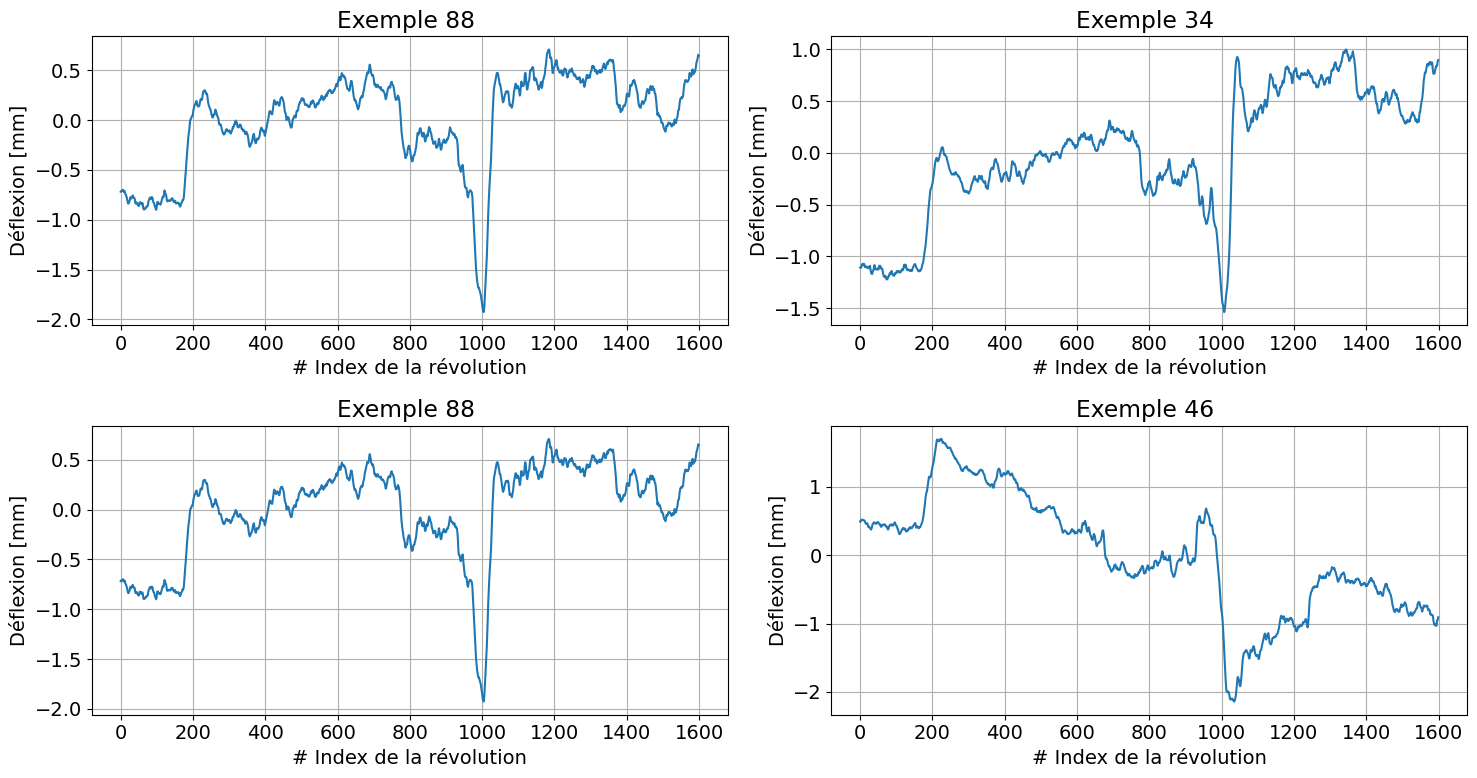

In [96]:
i = np.random.randint(5,np.shape(df)[1]-4,4)
it = 0
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 14})
for p in i:
    it+=1
    plt.subplot(2,2,it)
    plt.plot(X_ct[p,:])
    plt.grid()
    plt.title('Exemple {} '.format(p))
    plt.xlabel('# Index de la révolution')
    plt.ylabel('Déflexion [mm]')
plt.tight_layout()
plt.show()

## Correction par les différentes approches

In [97]:
x = np.zeros((Na*Nct,))
df_error = pd.DataFrame({                      
                         'ssim_autozero': x,
                         'ssim_pls': x,
                         'ssim_unet': x,
                         'cossim_autozero': x,
                         'cossim_pls': x,
                         'cossim_unet':x})

### Correction par auto-zero et calcul des métriques

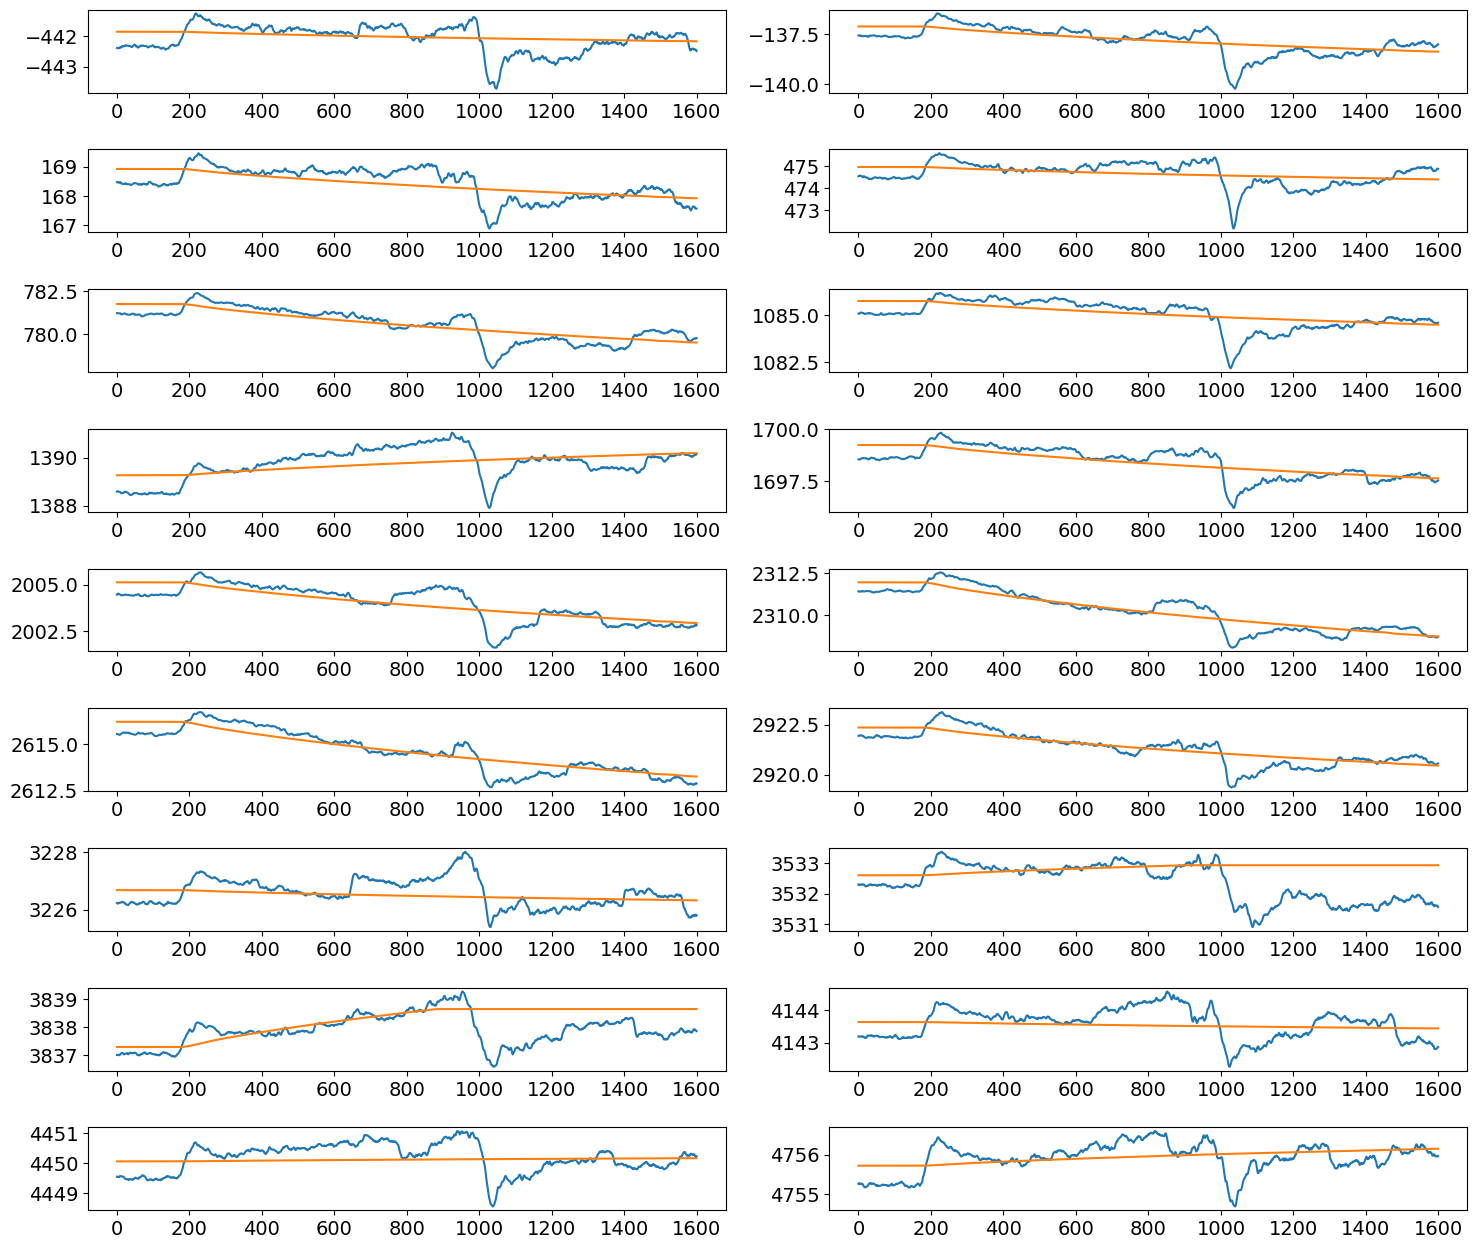

In [98]:
from autozero import *
ordre = 1
S = 0.2 #,0.3,0.4]
# SIGNAL_LENGTH = 1600    
Dzero = autozero(DCt_raw[:,:SIGNAL_LENGTH,:], Fr[:SIGNAL_LENGTH], ordre, S, 5)
plt.tight_layout()
plt.show()

tmp2 = []
tmp1 = []

for aub in range(np.shape(Dzero)[0]):
    for capt in range(np.shape(Dzero)[2]):
        tmp2.append(ssim(Dzero[aub,:SIGNAL_LENGTH,capt],X_ct[Nct*aub+capt,:,0]))
        tmp1.append(cosine_similarity(Dzero[aub,:SIGNAL_LENGTH,capt],X_ct[Nct*aub+capt,:,0]))

df_error['cossim_autozero'] = np.array(tmp1)
df_error['ssim_autozero'] = np.array(tmp2)


### Correction par la PLS et calcul des métriques 

In [78]:
#Algo NasPLS

# Matrice de lissage de l'estimation
from scipy import stats
from scipy.sparse import diags # manipuler des matrices creuses (rapide pour gros signaux)
from scipy.sparse.linalg import spsolve # résoudre des systèmes linéaires (calculs de baseline)
def mat_diff_snd_ordre(N):
    diagonals = [np.ones(N), -2*np.ones(N), np.ones(N)]
    return diags(diagonals, [0, 1, 2], shape=(N-2, N))


def naspls(y, lambdas, niter=15, tol=1e-4, y_baseline=None,epsilon=0.99):
    """y est le signal à corriger, mask est le masque des zones non sensibles, lambda est le paramètre de régularisation, niter le nombre d'itérations,
    tol la tolérance pour la convergence et y_baseline est optionnel c'est la baseline réelle utilisée en simulation pour évaluer la performance."""

    N = len(y)
    D = mat_diff_snd_ordre(N)

    best_rmse = np.inf
    best_z = None
    best_lambda = None
    base_estimated = []
    rmse_bas = []
    corr_coeff = []
    for lam in lambdas:
    
        w = np.ones(N) # poids pour chaque point du signal
        alpha = np.ones(N) # poids d’adaptation pour la régularisation (spécificité NasPLS)
        z = np.zeros(N) # baseline initiale (mise à zéro pour la première itération)
        i = 0
        for i in range(niter):
            W = diags(w, 0)
            A = W + lam * diags(alpha, 0) @ (D.T @ D)
            z_new = spsolve(A, W @ y)
            alpha = np.abs(y - z_new) / (np.max(np.abs(y - z))) # Mise à jour de alpha. Qd la différence en val abs de y-z_new est grande, la pénalité de régularisation est ajustée pour que la baseline ne suive pas de trop près les pics.
            
            
            d = y - z_new
        
            d_neg = d[d<0]
            # Éviter la division par zéro si d_neg est vide ou si l'écart-type est nul
            if len(d_neg) > 0 and np.std(d_neg) != 0:
                s = np.std(d_neg)
                m = np.mean(d_neg)
                # Variante de la fonction sigmoïde pour la mise à jour des poids
                w_new = 1 / (1 + np.exp(4*(d - (-1*m+2*s)) / s))
            else: # Si pas de points sous la ligne de base, garder les poids
                #print(True)
                w_new = np.ones(N)

            if np.linalg.norm(w_new - w) / (np.linalg.norm(w)) < tol:
                break
        
            w = w_new
            z = z_new

        base_estimated.append(z)
        if y_baseline!=None:
            rmse_bas.append(np.sqrt(np.mean((z - y_baseline)**2)))
        else:
            rmse_bas = 0
        corr_coeff.append(stats.spearmanr(np.gradient(y-z), np.gradient(y))[0])
    
    base_estimated = np.array(base_estimated)
    rmse_bas = np.array(rmse_bas)
    corr_coeff = np.array(corr_coeff)
    corr_coeff = np.abs(corr_coeff)
    i = 0
    while i <(len(corr_coeff)):
        # print(i) np.abs(corr_coeff[i+1]-corr_coeff[i])/corr_coeff[0]>1e-6 and 
        if corr_coeff[i]<epsilon and np.max(np.abs(base_estimated[i,:]))>1e-13:
            i = i+1
            # print(np.abs(corr_coeff[i+1]-corr_coeff[i])/corr_coeff[0])
            # print(np.max(np.abs(base_estimated[i,:])))
        else:
            pos = i-1
            # print('index',pos)
            break

    best_z = z
    # best_z = base_estimated[pos,:]
    # best_lambda = lambdas[pos]

    return best_z, best_lambda, rmse_bas,corr_coeff

In [101]:
# Estimation baseline par NasPLS
l_range = np.array(np.logspace(6,6,1))

baseline = []
for i in range(np.shape(X_ct)[0]):
    for lambdas in l_range:
        best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)
        baseline.append(best_base)
        df_error.loc[i,'ssim_pls'] = ssim(X_ct[i,:,0],X_ct[i,:,0]-best_base)
        df_error.loc[i,'cossim_pls'] = cosine_similarity(X_ct[i,:,0],X_ct[i,:,0]-best_base)

baseline = np.array(baseline)

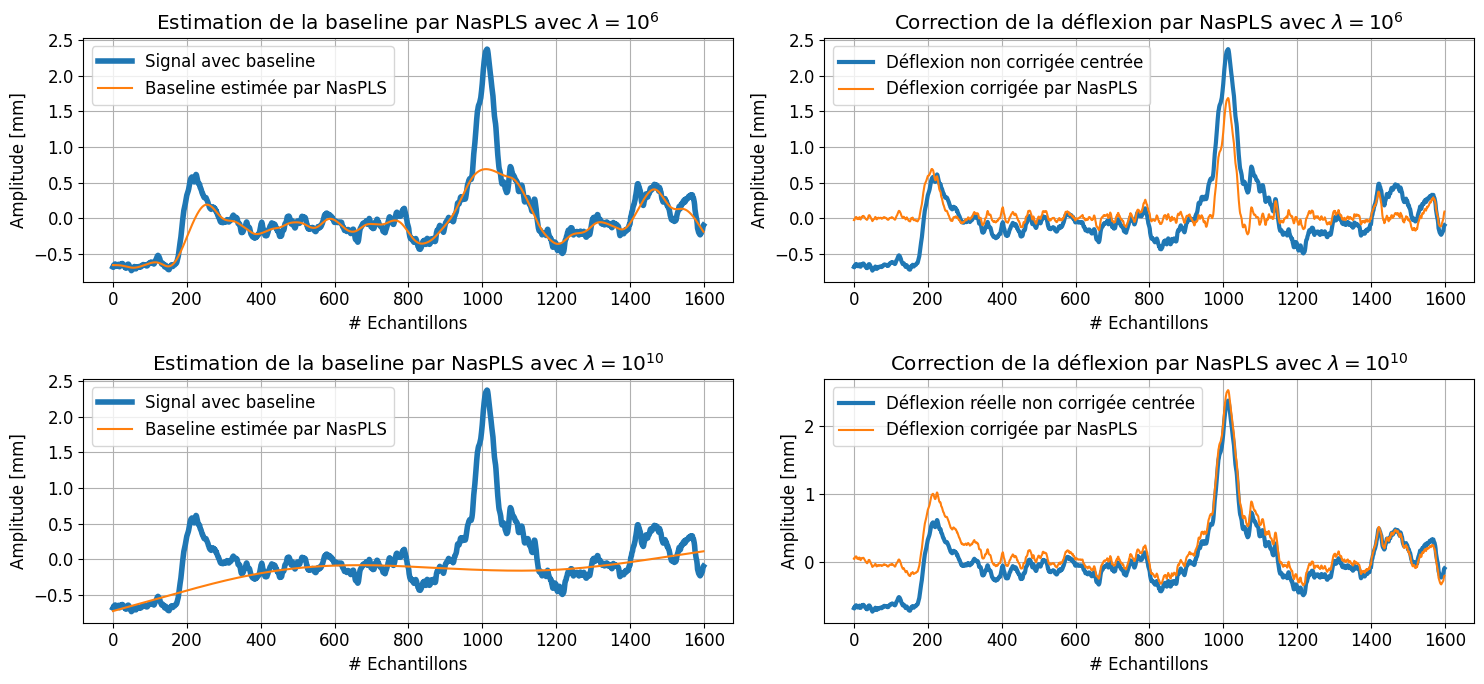

In [100]:
# Exemple de correction de la déflexion par NasPLS pour quelques valeurs de lambda
i = np.random.randint(0,Na*Nct)
lambdas = 10**(6)
best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)

fig = plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size': 12})
plt.subplot(2,2,1)
plt.plot(X_ct[i,:,0],label='Signal avec baseline',linewidth=4)

plt.plot(best_base,label='Baseline estimée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [mm]')
plt.grid()
plt.legend()
plt.title(r'Estimation de la baseline par NasPLS avec $\lambda = 10^{6}$ ')
plt.subplot(2,2,2)
plt.plot(X_ct[i,:,0],linewidth=3,label='Déflexion non corrigée centrée')
plt.plot(X_ct[i,:,0]-best_base,label='Déflexion corrigée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [mm]')
plt.grid()
plt.legend()
plt.title(r'Correction de la déflexion par NasPLS avec $\lambda = 10^{6}$')

lambdas = 1e10
best_base, best_lambda,rmse_bas,corr_coeff = naspls(X_ct[i,:,0],[lambdas],niter=20,tol=1e-8,y_baseline=None,epsilon=0.99)

plt.subplot(2,2,3)
plt.plot(X_ct[i,:,0],label='Signal avec baseline',linewidth=4)

plt.plot(best_base,label='Baseline estimée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [mm]')
plt.grid()
plt.legend()
plt.title(r'Estimation de la baseline par NasPLS avec $\lambda = 10^{10}$')
plt.subplot(2,2,4)
plt.plot(X_ct[i,:,0],linewidth=3,label='Déflexion réelle non corrigée centrée')
plt.plot(X_ct[i,:,0]-best_base,label='Déflexion corrigée par NasPLS')
plt.xlabel('# Echantillons')
plt.ylabel(r'Amplitude [mm]')
plt.grid()
plt.legend()
plt.title(r'Correction de la déflexion par NasPLS avec $\lambda = 10^{10}$')

plt.tight_layout()
plt.show()

### Correction par UNET et calcul des métriques 

In [47]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential

In [102]:
from tensorflow.keras.models import load_model
model_unet = load_model('best_model_unet_1600_200.h5')

import pickle
scaler = pickle.load(open('scaler_1600.pkl','rb')) 

In [ ]:
def predict_unet(model,scaler,X_ct,N=1600):
    L = np.shape(X_ct)[1]
    K = int(np.fix(L/N))
    Y_pred = np.zeros(np.shape(X_ct))
    for i in range(K):
        X_temp = X_ct[:,i*N:(i+1)*N,:]
        X_scaled = scaler.transform(X_temp[:,:,0])
        Y_pred[:,i*N:(i+1)*N,:] = model.predict(np.squeeze(X_scaled[...,np.newaxis], axis=-1))

    if L-K*N != 0:
        r = L-K*N  # Number of sample left
        X_temp = X_ct[:,L-N:L,:]
        Y_pred_end = np.zeros(np.shape(X_temp))
        print(np.shape(X_temp))
        X_scaled = scaler.transform(X_temp[:,:,0])
        Y_pred_end = model.predict(np.squeeze(X_scaled[...,np.newaxis], axis=-1))

    # Overlapping add
    print(np.shape(Y_pred_end[:,:(N-(L-K*N)),:]))
    Y_pred[:,L-N:K*N,:] = 0.5*(Y_pred[:,L-N:K*N,:] + Y_pred_end[:,:(N-(L-K*N)),:])
    
    Y_pred[:,K*N:L,:] = Y_pred_end[:,(N-(L-K*N)):,:]  

    return Y_pred  

In [103]:
# Correction par UNET

# Normalisation de la donnée par le scaler
X_scaled = scaler.transform(X_ct[:,:,0])
# Prédiction du signal sans baseline par le modèle entrainé
Y_pred = model_unet.predict(np.squeeze(X_scaled[...,np.newaxis], axis=-1))

# Y_pred = predict_unet(model_unet,scaler,X_ct,N=1600)

for i in range(np.shape(X_ct)[0]):
    df_error.loc[i,'ssim_unet'] = ssim(X_ct[i,:,0],Y_pred[i,:,0])
    df_error.loc[i,'cossim_unet'] = cosine_similarity(X_ct[i,:,0],Y_pred[i,:,0])


4/4 [==============================] - 1s 197ms/step


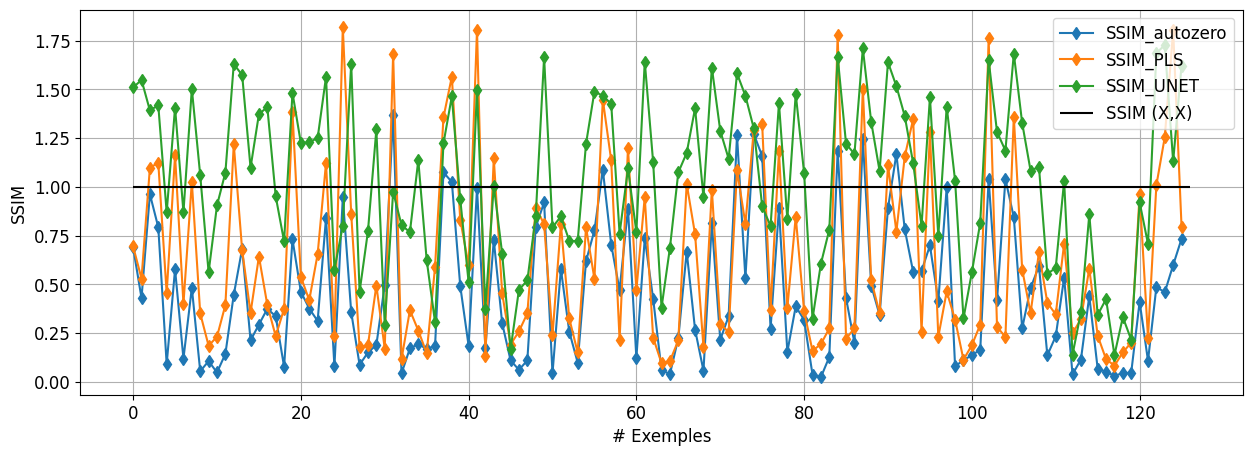

In [104]:
plt.figure(figsize=(15,5))
plt.plot(df_error[['ssim_autozero','ssim_pls','ssim_unet']],'-d',label=['SSIM_autozero','SSIM_PLS','SSIM_UNET'])
plt.xlabel('# Exemples')
plt.hlines(xmin=0,xmax=len(X_ct),y=1,colors='k',label='SSIM (X,X)')
plt.ylabel('SSIM')
plt.grid()
plt.legend()
# plt.ylim(0,2)
plt.show()


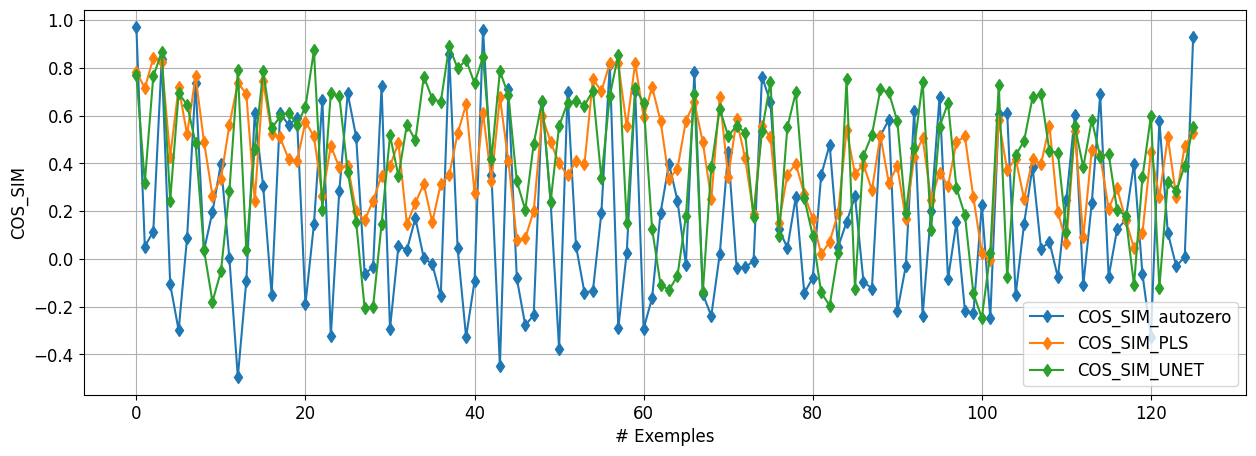

In [105]:
plt.figure(figsize=(15,5))
plt.plot(df_error[['cossim_autozero','cossim_pls','cossim_unet']],'-d',label=['COS_SIM_autozero','COS_SIM_PLS','COS_SIM_UNET'])
plt.xlabel('# Exemples')
plt.ylabel('COS_SIM')
plt.grid()
plt.legend()
plt.show()

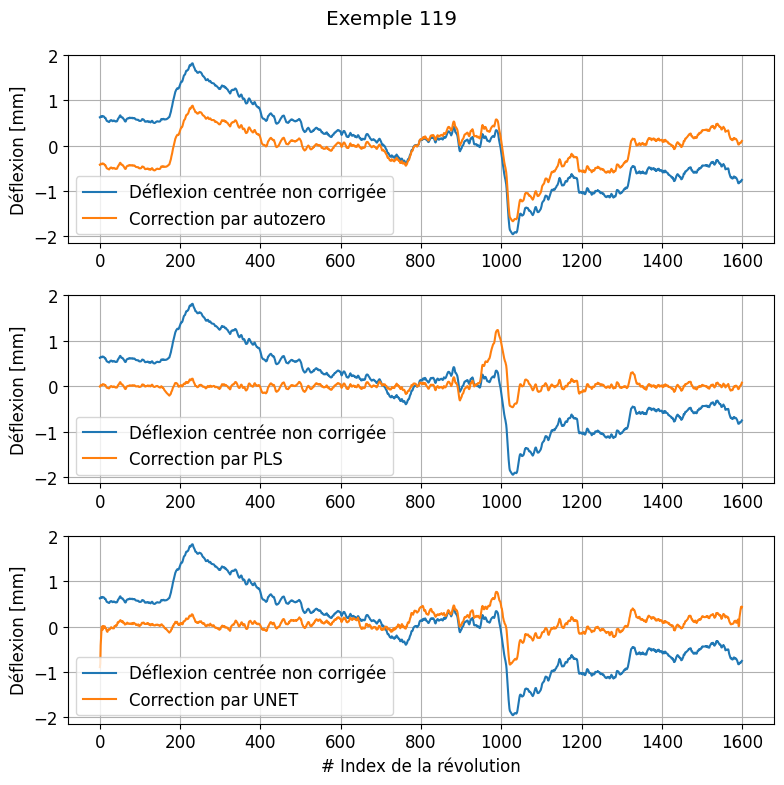

In [119]:
aub = np.random.randint(0,Na,1)
capt = np.random.randint(0,Nct,1)

import matplotlib.pyplot as plt
import seaborn as sns
p = aub[0]+capt[0]*Na
fig = plt.figure(figsize=(8,8))
j = 0
for i in [p]:
    j  =j+1
    plt.subplot(3,1,1)
    plt.plot(X_ct[i,:,0],label='Déflexion centrée non corrigée')
    plt.plot(Dzero[aub[0],:SIGNAL_LENGTH,capt[0]],label='Correction par autozero')
    # plt.ylim(min(X_ct[i,:,0]),max(X_ct[i,:,0]))
    plt.ylabel('Déflexion [mm]')
    plt.grid()
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(X_ct[i,:,0],label='Déflexion centrée non corrigée')
    plt.plot(X_ct[i,:,0]-baseline[i,:],label='Correction par PLS')
    plt.ylabel('Déflexion [mm]')
    # plt.ylim(min(X_ct[i,:,0]),max(X_ct[i,:,0]))
    plt.grid()
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(X_ct[i,:,0],label='Déflexion centrée non corrigée')
    plt.plot(Y_pred[i,:,0],label='Correction par UNET')
    # plt.ylim(min(X_ct[i,:,0]),max(X_ct[i,:,0]))
    plt.xlabel('# Index de la révolution')
    plt.grid()
    plt.ylabel('Déflexion [mm]')

    plt.legend()
    plt.suptitle('Exemple {}'.format(i))
    

plt.tight_layout()


fig.savefig('exemple{}.png'.format(p))
plt.show()
plt.close(fig)

## Conclusion
La correction des données réelles montrent visuellement que les deux nouvelles méthodes (PLS et UNET) sont pls performantes que la méthode traditionnelle.

Dans la suite du porojet, il faudrait trouver une métrique permettant de comparer la performance des méthodes proposées sur les données réelles. 

Afin d'avoir une correction de la déflexion par le modèle UNET plus fiable et robuste, il seraitjudicieux d'entrainer ledit modèle sur une base de données réelles de déflexions corrigées manuellement par la PLS.   